![data-x](http://oi64.tinypic.com/o858n4.jpg)


# Data-X Notebook: NLP & NLTK
#### Using Natural Language Processing in Python to do sentiment analysis on IMDB movie reviews

Author: Alexander Fred Ojala

Source: 
- https://www.kaggle.com/c/word2vec-nlp-tutorial/data
- https://github.com/rasbt/python-machine-learning-book/tree/master/code
- https://github.com/justmarkham/pycon-2016-tutorial

*Code snippets given run on both Python 2.7 and Python 3.x


# Table of Contents:

### - [Part 0: Pre-Setup & Data description](#sec0)
### - [Part 1: Explore the Data](#sec1)
### - [Part 2: NLTK intro (1 review) cleaning, tokenizing, stemming, lemmatization, stopwords](#sec2)
### - [Part 3: Preparing the data set for classification](#sec3)
### - [Part 4: Sentiment Classification w scikit-learn, Feature vectors & Bag of Words model](#sec4)
#### - [Appendix: Submitting to Kaggle & possible extensions](#sec5)

<div id='sec0'></div>

## Part 0: Pre-Setup & Data description

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# make compatible with Python 2 and Python 3
from __future__ import print_function, division, absolute_import 

# Data description

You can download the data (labeledTrainData.tsv.zip) here: https://www.kaggle.com/c/word2vec-nlp-tutorial/data, place it in your working directory & unzip the file. (It is placed in the data folder if you cloned the Github repo)

## Data set

The labeled training data set consists of 25,000 IMDB movie reviews. There is also an unlabeled test set with 25,000 IMDB movie reviews. The sentiment of the reviews are binary, meaning an IMDB rating < 5 results in a sentiment score of 0, and a rating >=7 have a sentiment score of 1 (no reviews with score 5 or 6 are included in the analysis). No individual movie has more than 30 reviews.

## File description

* **labeledTrainData** - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review. 

* **testData** - The unlabeled test set. 25,000 rows containing an id, and text for each review. 

## Data columns
* **id** - Unique ID of each review
* **sentiment** - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* **review** - Text of the review


# Part 1: Explore the data

In [2]:
!head -n3 data/labeledTrainData.tsv 
# use bash command to see data set structure

id	sentiment	review
"5814_8"	1	"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual featu

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in the data to a Pandas data frame
# Use header = 0 (first line contains col names)
# use delimiter=\t (columns are separated by tabs),
# use quoting=3 (Python will ignore doubled quotes)

train = pd.read_csv("data/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
# train.shape should be (25000,3)


test = pd.read_csv("data/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

# Data set info


In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [6]:
train.info() # no NaN's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


### 1. Class balance: How many movie reviews are positive and how many are negative in labeledTrainData.tsv? Do we have balance between the classes?

(25000, 3)

Number of Data Samples for every label output. 0 = Negative, 1 = postive:
1    12500
0    12500
Name: sentiment, dtype: int64


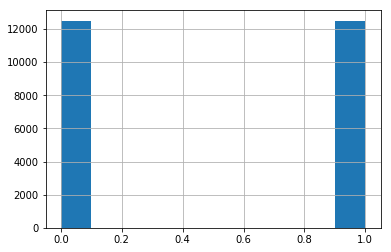

In [7]:
# 1. 
print(train.shape)
print()
print('Number of Data Samples for every label output. 0 = Negative, 1 = postive:')
print(train.sentiment.value_counts())

train.sentiment.hist(); #class balance

### 2: What is the average length of all the reviews (string length)?

In [8]:
# 2. Apply length function to the review column
lengths = train['review'].apply(len)

print('Average character length of the reviews are:')
print (np.mean(lengths))

Average character length of the reviews are:
1329.71056


<div id='sec2'></div>

# Part 2: 
## NLTK intro (1 review) cleaning, tokenizing, stemming, lemmatization, stopwords

Let's explore NLP by looking at the third review in the training data set, i.e. `train['review'][2]`

In [9]:
# import packages

import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

eng_stopwords = stopwords.words('english')

# TO DOWNLOAD NLTK CORPORA
Run the below command in an empty cell
```python
nltk.download()
```

Then, download `Corpora / stopwords` and `Models / punkt` and `Models / Averaged Perceptron` and `corpora / wordnet`

.

*__Text Corpus__ = Large and structured set of texts for statistical analysis*

In [10]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Start by analysing one review (review 3)

In [11]:
review3 = train['review'][2] # the review used for initial analysis
print(review3)

"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight against on

## Clean the review

First we would like to clean up the reviews. As you can see many interviews contain \ characters in front of quotation symobols, "`<br/>` tags, numbers, abbrevations etc.

### 1: Remove all the HTML tags in the third review, by creating a beatifulsoup object and then using the `.text` attribute. Save results in variable `review3

In [12]:
# 1.
review3 = bs.BeautifulSoup(review3, features='lxml').text # removes HTML tags
print(review3[:1150])

"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon . Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger . In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons. The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing. The giant animals savagely are stalking its prey and the group run afoul and fight against on

### 2: Import NLTK's sent_tokenizer and count the number of sentences in review 3 
The review should be cleaned from HTML tags. To import sent_tokenizer use: `from nltk.tokenize import sent_tokenize`

In [13]:
print(len(sent_tokenize(review3)))
sent_tokenize(review3) # doesn't really split all sentences

13


['"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park .',
 "A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon .",
 'Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger .',
 'In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons.',
 'The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing.',
 "The giant animals savagely are stalking its prey and the group run afou

In [14]:
# Check if it does a better job if we add space after every period
review3 = review3.replace('.','. ')

print(len(sent_tokenize(review3)), end='\n\n') # number of sentences

# print all sentences on a new line
for sent in sent_tokenize(review3):
    print(sent, end='\n\n')

20

"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park .

A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearsome predators, the Sabretooth tiger or Smilodon .

Scientific ambition turns deadly, however, and when the high voltage fence is opened the creature escape and begins savagely stalking its prey - the human visitors , tourists and scientific.

Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large pre-historical animals which are deadlier and bigger .

In addition , a security agent (Stacy Haiduk) and her mate (Brian Wimmer) fight hardly against the carnivorous Smilodons.

The Sabretooths, themselves , of course, are the real star stars and they are astounding terrifyingly though not convincing.

The giant animals savagely are stalking its prey and the group run afoul and fight

### 3: Remove all punctuation and special characters from the third review.
We can do this using Regular Expression - package `re`. Regular expression define search patterns for text that can be used to search, replace, substitute etc. certain patterns in text data.

We'll use regular expression to only look for alphabetical characters, `[^a-zA-Z]`. Save results in variable `review3`

Intro to Regex: http://www.aivosto.com/vbtips/regex.html

In [15]:
review3 = re.sub('[^a-zA-Z ]' ,'',review3)
print(review3) # remove special characters

The film starts with a manager Nicholas Bell giving welcome investors Robert Carradine to Primal Park   A secret project mutating a primal animal using fossilized DNA like Jurassik Park and some scientists resurrect one of natures most fearsome predators the Sabretooth tiger or Smilodon   Scientific ambition turns deadly however and when the high voltage fence is opened the creature escape and begins savagely stalking its prey  the human visitors  tourists and scientific Meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large prehistorical animals which are deadlier and bigger   In addition  a security agent Stacy Haiduk and her mate Brian Wimmer fight hardly against the carnivorous Smilodons  The Sabretooths themselves  of course are the real star stars and they are astounding terrifyingly though not convincing  The giant animals savagely are stalking its prey and the group run afoul and fight against one natures most fearsome 

### 4: Convert all the letters to lower case, split the string so that every word is one element in a list
Note: When we split the strings into words that process is called tokenization.

In [16]:
review3 = review3.lower()
review3

'the film starts with a manager nicholas bell giving welcome investors robert carradine to primal park   a secret project mutating a primal animal using fossilized dna like jurassik park and some scientists resurrect one of natures most fearsome predators the sabretooth tiger or smilodon   scientific ambition turns deadly however and when the high voltage fence is opened the creature escape and begins savagely stalking its prey  the human visitors  tourists and scientific meanwhile some youngsters enter in the restricted area of the security center and are attacked by a pack of large prehistorical animals which are deadlier and bigger   in addition  a security agent stacy haiduk and her mate brian wimmer fight hardly against the carnivorous smilodons  the sabretooths themselves  of course are the real star stars and they are astounding terrifyingly though not convincing  the giant animals savagely are stalking its prey and the group run afoul and fight against one natures most fearsome

In [17]:
review3_words = review3.split()
print(review3_words[:20]) # tokenize and lower case

['the', 'film', 'starts', 'with', 'a', 'manager', 'nicholas', 'bell', 'giving', 'welcome', 'investors', 'robert', 'carradine', 'to', 'primal', 'park', 'a', 'secret', 'project', 'mutating']


## 5: Stemming
Use NLTK's PorterStemmer (`from nltk.stem import PorterStemmer`). Create a new Porter stemmer (`stemmer = PorterStemmer()`) and run it on every word in `review3_words`, print the results as one string (don't overwrite the `review3_words` variable from 4). 

**What does the PorterStemmer do?**
PorterStemmer tries treating similar words as the same (e.g. give, gives, given = give).

**Stemming (paraphrased from Wiki):** Stemming reduces words to their word stem, base or root form (i.e. similar words, with the same stem, will be interpreted as the same)

In [18]:
review3_words[2]

'starts'

In [19]:
ps = PorterStemmer() # instantiate empty Porter Stemmer object
ps.stem('starting')

'start'

In [20]:

ps_stems = []
for w in review3_words:
    ps_stems.append(ps.stem(w))

print(' '.join(ps_stems)) # add all the stemmed words to one string

the film start with a manag nichola bell give welcom investor robert carradin to primal park a secret project mutat a primal anim use fossil dna like jurassik park and some scientist resurrect one of natur most fearsom predat the sabretooth tiger or smilodon scientif ambit turn deadli howev and when the high voltag fenc is open the creatur escap and begin savag stalk it prey the human visitor tourist and scientif meanwhil some youngster enter in the restrict area of the secur center and are attack by a pack of larg prehistor anim which are deadlier and bigger in addit a secur agent staci haiduk and her mate brian wimmer fight hardli against the carnivor smilodon the sabretooth themselv of cours are the real star star and they are astound terrifyingli though not convinc the giant anim savag are stalk it prey and the group run afoul and fight against one natur most fearsom predat furthermor a third sabretooth more danger and slow stalk it victim the movi deliv the good with lot of blood 

### 6 Part of Speech tagging
Now we want to Part Of Speech (POS)) tag the third movie review. We will use POS labeling, also called grammatical tagging. To do this import `from nltk.tag import pos_tag`. 

When you use `pos_tag` on a word it returns a token-tag pair in the form of a tuple. In NLTK's Penn Treebank POS, the abbreviation (tag) for an adjective is JJ and NN for singular nouns. 

Let's count the number of singular nouns (NN) and adjectives (JJ) in `review3_words` using NLTK's pos_tag. A list of the Penn Treebank pos_tag's can be found here: http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [21]:
# 6.
token_tag = pos_tag(review3_words)
token_tag[:10]

[('the', 'DT'),
 ('film', 'NN'),
 ('starts', 'VBZ'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('manager', 'NN'),
 ('nicholas', 'NN'),
 ('bell', 'NN'),
 ('giving', 'VBG'),
 ('welcome', 'JJ')]

In [22]:
# Cell that count nouns (NN) and adjectives (JJ) in review3
NN_count = 0
JJ_count = 0

for pair in token_tag:
    tag = pair[1]
    if tag == 'JJ':
        JJ_count+=1
    elif tag == 'NN':
        NN_count+=1
print('Number of nouns:', NN_count)
print('Number of adjectives:', JJ_count)

Number of nouns: 83
Number of adjectives: 44


## 7. Lemmatizing
An even more sophisticated operation than stemming using the PorterStemmer is called lemmatizing. 

Lemmatizing, in contrast to stemming, does not create non-existent words and converts words to their synonyms. In order to use lemmatizing we need to define the wordnet POS tag. A function that takes in a POS Penn Treebank tag and converts it to a wordnet tag and then lemmatizes words in a string has been given written below. 

**Lemmatization (paraphrased from Wiki):** Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

We can use this to print the lemmatized third movie review.

In [23]:
# 7.

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [24]:
from nltk.stem import WordNetLemmatizer


wnl = WordNetLemmatizer()

print('POS token and tag:',token_tag[2])
print('Word net tag:',get_wordnet_pos(token_tag[2][1]))

POS token and tag: ('starts', 'VBZ')
Word net tag: v


In [25]:
print('Lemmatized version of word the word "{}":'.format(token_tag[2][0]), \
      wnl.lemmatize(token_tag[2][0],pos=get_wordnet_pos(token_tag[2][1])))

Lemmatized version of word the word "starts": start


In [26]:
# Lemmatize the full review

wnl_stems = []
for pair in token_tag:
    res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
    wnl_stems.append(res)

print(' '.join(wnl_stems))

the film start with a manager nicholas bell give welcome investor robert carradine to primal park a secret project mutate a primal animal use fossilized dna like jurassik park and some scientist resurrect one of nature most fearsome predator the sabretooth tiger or smilodon scientific ambition turn deadly however and when the high voltage fence be open the creature escape and begin savagely stalk it prey the human visitor tourist and scientific meanwhile some youngster enter in the restricted area of the security center and be attack by a pack of large prehistorical animal which be deadlier and big in addition a security agent stacy haiduk and her mate brian wimmer fight hardly against the carnivorous smilodons the sabretooths themselves of course be the real star star and they be astound terrifyingly though not convince the giant animal savagely be stalk it prey and the group run afoul and fight against one natures most fearsome predator furthermore a third sabretooth more dangerous a

## 8. StopWords

Lastly we will remove common words that don't carry much information. These are called stopwords. 

In English they could for example be 'am', 'are', 'and' etc. 

To import NLTK's list of stopwords you need to download the stopword corpora (`import nltk` and then `nltk.download()` if you don't have it). 

When that is done run `from nltk.corpus import stopwords` and create a variable for English stopwords with `eng_stopwords = stopwords.words('english')`. Use the list of English stopwords to remove all the stopwords from your list of words in the third movie review, i.e. `review3_words`. Print `review3_words` without stopwords, count the number of stopwords removed and print them as well.

In [27]:
from nltk.corpus import stopwords

eng_stopwords = stopwords.words('english')
print(eng_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
review3_wo_stopwords = [w for w in review3_words if not w in stopwords.words("english")]
removed_stopwords = [w for w in review3_words if w in stopwords.words("english")]

print('REVIEW WITHOUT STOPWORDS:')
print(' '.join(review3_wo_stopwords))
print()
print('Stop words removed', removed_stopwords)
print()
print('NUMBER OF STOPWORDS REMOVED:',len(removed_stopwords))

REVIEW WITHOUT STOPWORDS:
film starts manager nicholas bell giving welcome investors robert carradine primal park secret project mutating primal animal using fossilized dna like jurassik park scientists resurrect one natures fearsome predators sabretooth tiger smilodon scientific ambition turns deadly however high voltage fence opened creature escape begins savagely stalking prey human visitors tourists scientific meanwhile youngsters enter restricted area security center attacked pack large prehistorical animals deadlier bigger addition security agent stacy haiduk mate brian wimmer fight hardly carnivorous smilodons sabretooths course real star stars astounding terrifyingly though convincing giant animals savagely stalking prey group run afoul fight one natures fearsome predators furthermore third sabretooth dangerous slow stalks victims movie delivers goods lots blood gore beheading hairraising chillsfull scares sabretooths appear mediocre special effects story provides exciting stir

<div id='sec3'></div>

# Part 3: Preparing the data set for classification

In this part we'll put everything that we've learned so far together. This so that we can use our reviews to make accurate predicitons on their sentiment.

## 1. Review cleaning function

We'll create a function called `review_cleaner` that reads in a review and:

- Removes HTML tags (using beautifulsoup)
- **Extract emoticons (emotion symbols, aka smileys :D )**
- Removes non-letters (using regular expression)
- Converts all words to lowercase letters and tokenizes them (using .split() method on the review strings, so that every word in the review is an element in a list)
- Removes all the English stopwords from the list of movie review words
- Join the words back into one string seperated by space, append the emoticons to the end

**NOTE: Transform the list of stopwords to a set before removing the stopwords. I.e. assign `eng_stopwords = set(stopwords.words("english"))`. Use the set to look up stopwords. This will speed up the computations A LOT (Python is much quicker when searching a set than a list).**

In [29]:
# 1. 
from nltk.corpus import stopwords


def review_cleaner(review):
    '''
    Clean and preprocess a review.
    
    1. Remove HTML tags
    2. Use regex to remove all special characters (only keep letters)
    3. Make strings to lower case and tokenize / word split reviews
    4. Remove English stopwords
    5. Rejoin to one string
    '''
    
    #1. Remove HTML tags
    review = bs.BeautifulSoup(review).text
    
    #2. Use regex to find emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)
    
    #3. Remove punctuation
    review = re.sub("[^a-zA-Z]", " ",review)
    
    #4. Tokenize into words (all lower case)
    review = review.lower().split()
    
    #5. Remove stopwords
    eng_stopwords = set(stopwords.words("english"))
    review = [w for w in review if not w in eng_stopwords]
    
    #6. Join the review to one sentence
    review = ' '.join(review+emoticons)
    # add emoticons to the end

    return(review)

## 2. Create original, Porter Stemmed, and Lemmatized data sets
    
**Create three lists `review_clean_original`, `review_clean_ps` and `review_clean_wnl`.**

- `review_clean_original` contains all the reviews from the train DataFrame, that have been cleaned by the function `review_cleaner` defined above.

- `review_clean_ps` applies the PorterStemmer to the reviews in `review_clean_original`. **Note:** NLTK version 3.2.2 crashes when trying to use the PorterStemming on the string 'oed' (known bug). Therefore, use an if statement to skip just that specific string/word.

- `review_clean_wnl` contains words that have been lemmatized using NLTK's WordNetLemmatizer on the words in the list `review_clean_original`.
    
**Note: This can take more than 10minutes to run on a laptop**

In [30]:
%%time

num_reviews = len(train['review'])

review_clean_original = []

for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    review_clean_original.append(review_cleaner(train['review'][i]))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

In [31]:
%%time
# Porter stemming on the results in review_clean_original

review_clean_ps = []

ps = PorterStemmer()


for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    ps_stems = []
    for w in review_clean_original[i].split():
        if w == 'oed':
            continue
        ps_stems.append(ps.stem(w))
    
    review_clean_ps.append(' '.join(ps_stems))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

In [32]:
%%time
# Lemmatizer

review_clean_wnl = []

wnl = WordNetLemmatizer()

for i in range(0,num_reviews):
    if( (i+1)%500 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    
    wnl_stems = []
    token_tag = pos_tag(review_clean_original[i].split())
    for pair in token_tag:
        res = wnl.lemmatize(pair[0],pos=get_wordnet_pos(pair[1]))
        wnl_stems.append(res)

    review_clean_wnl.append(' '.join(wnl_stems))

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews
Done with 9500 reviews
Done with 10000 reviews
Done with 10500 reviews
Done with 11000 reviews
Done with 11500 reviews
Done with 12000 reviews
Done with 12500 reviews
Done with 13000 reviews
Done with 13500 reviews
Done with 14000 reviews
Done with 14500 reviews
Done with 15000 reviews
Done with 15500 reviews
Done with 16000 reviews
Done with 16500 reviews
Done with 17000 reviews
Done with 17500 reviews
Done with 18000 reviews
Done with 18500 reviews
Done with 19000 reviews
Done with 19500 reviews
Done with 20000 reviews
Done with 20500 reviews
Done with 21000 reviews
Done with 21

<div id='sec4'></div>

# Part 4: Sentiment Classification w scikit-learn, Feature vectors & Bag of Words model

### Bag of Words: Explanation


We will now use scikit-learn to create numeric representations of the words in the reviews, using a method called Bag of Words. You can see this as learning a vocabulary from all the reviews and counting how many times a word appears in the reviews. For example, if we have two sentences:

**Sentence 1:** "cool students study cool data science"

**Sentence 2:** "to know data science study data science"

The vocabulary of these two sentences can be summarized in a dictionary:

    { cool, students, study, data, science, to, know }

The bag of words representation of the two sentences above will count the number of times each word occur in a sentence. In Sentence 1, "cool" appears twice, and "students", "study", "data", and "science" appear once. The feature vector for Sentence 1 is:

    Sentence 1: { 2, 1, 1, 1, 1, 0, 0 }

    Sentence 2: { 0, 0, 1, 2, 2, 1, 1 }


The `fit` method in scikit-learns `CountVectorizer` creates the vocabulary of the bag-of-words model and fits the function to the data set you pass in.

The `transform` method in `CountVectorizer` transforms text input to a feature matrix, where the rows are the document inputs and the columns are the words / feature in the vocabulary.

In [44]:
## Example code BoW

from sklearn.feature_extraction.text import CountVectorizer

sent1 = "cool students study cool data science"
sent2 = "to know data science study data science"

vect = CountVectorizer() #instantiate

sents = np.array([sent1,sent2])

vect.fit(sents);


In [45]:
print('The words in the vocabulary (and position in feature matrix):\n')
print(vect.vocabulary_)

# vocabulary for the BoW model is stored in a dictionary

The words in the vocabulary (and position in feature matrix):

{'cool': 0, 'students': 4, 'study': 5, 'data': 1, 'science': 3, 'to': 6, 'know': 2}


In [46]:
# Transform to get feature vectors

X_bow = vect.transform(sents)

X_bow.toarray()

# the rows corresponds to the sentences 

array([[2, 1, 0, 1, 1, 1, 0],
       [0, 2, 1, 2, 0, 1, 1]])

In [47]:
vect.get_feature_names() # stored in the right places

['cool', 'data', 'know', 'science', 'students', 'study', 'to']

In [48]:
# Put it in a DataFrame for interpretability

pd.DataFrame(X_bow.toarray(), columns=vect.get_feature_names(), index=[sent1,sent2])

# the number in the DataFrame is called Raw Term frequency raw term frequencies: 
# tf (t,d)—the number of times a term t occurs in a document d.

,cool,data,know,science,students,study,to
cool students study cool data science,2,1,0,1,1,1,0
to know data science study data science,0,2,1,2,0,1,1


# Applying this strategy to the IMDB movie reviews

The movie review data contains a lot of words. To limit the analysis we use the 5000 most frequent words from the cleaned reviews. To extract the bag of words features we will use scitkit-learn.

The training data will be created by the `CountVectorizer` function from scikit-learn, and the training array will have 25000 rows (one for each review) and 5000 features (one for each vocabulary word).

CountVectorizer can automatically handle text cleaning, but here we specify `None`, instead we did a step-by-step cleaning of the data in the earlier problems.

#### Random Forest for review sentiment classification

First split up the data set so that 80% are used as training samples (the first 20000 reviews and their sentiment) and 20% are used as validation samples (the last 5000 reviews and their sentiment). Train Random Forest models on the different data sets. The number of trees is set to 75 and the max number of splits per Tree is set to 15 (regularization).


## Classify IMDB movie review dataset

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics # for confusion matrix, accuracy score etc
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(\
    review_clean_original, train['sentiment'], random_state=0, test_size=.2)


# CountVectorizer can actucally handle a lot of the preprocessing for us
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)

In [ ]:
%%time
# Transform the text data to feature
# Only fit training data (to mimic real world)

vectorizer.fit(X_train)

In [ ]:
# Check that it worked, 
# now we have fitted a model that can transform features
# to sparse matrix representation

print(vectorizer.get_feature_names()[:10])

In [ ]:
train_bag = vectorizer.transform(X_train) #transform to a feature matrix
val_bag = vectorizer.transform(X_val)

In [ ]:
print(train_bag.toarray().shape) # 20,000 reviews, 2,000 feartures. just as expected
print(val_bag.toarray().shape)

In [ ]:
print(type(train_bag)) # sparse matrix representation

print(train_bag)

## Clasify with Random Forest model

* Fit a Random Forest model to our bagged data set in order to do the sentiment analysis on `review_clean_original` and print the **validation accuracy** by using `forest.predict(val_bag)` and then comparing the resulting sentiment predictions with the ones stored in `y_val`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

## Initialize a Random Forest classifier with 75 trees, max splits 15
# hyperparameter n_estimators always set in instantiation

forest = RandomForestClassifier(n_estimators = 75,max_depth=15) 

In [ ]:
%%time
# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the target variable

forest = forest.fit(train_bag, y_train) # can take 20 seconds to run

In [ ]:
# Make predictions

train_predictions = forest.predict(train_bag)
valid_predictions = forest.predict(val_bag)

## Accuracy

In [ ]:
metrics.accuracy_score(y_train,train_predictions) 

In [ ]:
metrics.accuracy_score(y_val,valid_predictions) # 83% test

In [ ]:
# Confusion matrix
# Is the number of False Positives and True negatives approx 50/50?
metrics.confusion_matrix(y_val,valid_predictions)

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_val,valid_predictions).ravel()
fp, fn

In [ ]:
# What are the characteristics of False Positives for example?
# Good practice when doing analysis

df_test = pd.DataFrame(X_val)
df_test[(y_val.values==0) & (valid_predictions==1)]

## Feature importances

In [ ]:
importances = forest.feature_importances_
# returns relative importance of all features.
# they are in the order of the columns
print(importances)

In [ ]:
# sort importance scores
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
top_10 = indices[:10]

# Get top ten features
print([vectorizer.get_feature_names()[ind] for ind in top_10])

# Put everything together in a function

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# put everything together in a function

def predict_sentiment(cleaned_reviews, y=train["sentiment"]):

    print("Creating the bag of words model!\n")
    # CountVectorizer" is scikit-learn's bag of words tool, here we show more keywords 
    vectorizer = CountVectorizer(analyzer = "word",   \
                                 tokenizer = None,    \
                                 preprocessor = None, \
                                 stop_words = None,   \
                                 max_features = 2000) 
    
    X_train, X_test, y_train, y_test = train_test_split(\
    cleaned_reviews, y, random_state=0, test_size=.2)

    # Then we use fit_transform() to fit the model / learn the vocabulary,
    # then transform the data into feature vectors.
    # The input should be a list of strings. .toarraty() converts to a numpy array
    
    train_bag = vectorizer.fit_transform(X_train).toarray()
    test_bag = vectorizer.transform(X_test).toarray()

    # You can extract the vocabulary created by CountVectorizer
    # by running print(vectorizer.get_feature_names())


    print("Training the random forest classifier!\n")
    # Initialize a Random Forest classifier with 75 trees
    forest = RandomForestClassifier(n_estimators = 75, max_depth=15) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the target variable
    forest = forest.fit(train_bag, y_train)


    train_predictions = forest.predict(train_bag)
    test_predictions = forest.predict(test_bag)
    
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    print("The training accuracy is: ", train_acc, "\n", "The validation accuracy is: ", valid_acc)
    
    return(forest,vectorizer)

## Compare Original cleaned to lemmatized and stemmed data set

Now carry out the same analysis as above but on the `review_clean_ps` and `review_clean_wnl`. 

What data preprocessing strategy worked the best? Why do you think that is? (Feel free to change the number of features extracted in the bag of words model and the number of trees in the random forest model (i.e. the hyperparameters in our model), to see how it effects your accuracy. Is the accuracy better or worse?

In [ ]:
%%time

print('Original Reviews')
forest1,vec1 = predict_sentiment(review_clean_original)
print('Porter Stemmer')
forest2,vec2 = predict_sentiment(review_clean_ps)
print('Lemmatizing')
forest3,vec3 = predict_sentiment(review_clean_wnl)


#### It  seems like Porter Stemmer and Lemmatizing does not effect the results as much as we thought
###### This is just what Sebastian Raschka points out in his book Python Machine Learning:

```
The Porter stemming algorithm is probably the oldest and simplest
stemming algorithm. Other popular stemming algorithms include the
newer Snowball stemmer (Porter2 or "English" stemmer) or the Lancaster
stemmer (Paice-Husk stemmer), which is faster but also more aggressive
than the Porter stemmer. Those alternative stemming algorithms are also
available through the NLTK package (http://www.nltk.org/api/
nltk.stem.html).

While stemming can create non-real words, such as thu, (from thus) as
shown in the previous example, a technique called lemmatization aims to
obtain the canonical (grammatically correct) forms of individual words—
the so-called lemmas. However, lemmatization is computationally more
diffcult and expensive compared to stemming and, in practice, it has
been observed that stemming and lemmatization have little impact on the
performance of text classifcation (Michal Toman, Roman Tesar, and Karel
Jezek. Infuence of word normalization on text classifcation. Proceedings of
InSciT, pages 354–358, 2006).
```

<div id='sec5'></div>

## Appendix Kaggle submission code

In [ ]:
# If you want to submit to Kaggle
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

# Verify that there are 25,000 rows and 2 columns
print(test.shape)

# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
clean_test_reviews = [] 

print("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,num_reviews):
    if( (i+1) % 1000 == 0 ):
        print("Review %d of %d\n" % (i+1, num_reviews))
    clean_review = review_cleaner( test["review"][i] )
    clean_test_reviews.append( clean_review )



# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "BoW_results.csv", index=False, quoting=3 )

# Strategies to improve accuracy



# Extra Credit (worth 1p)

* **Question:** Preprocess the reviews in any way you find suitable and build your own ML model that can predict the sentiment of movie reviews. Credit will be given if you can obtain a prediction accuracy of over 90%, when predicting the sentiments of the validation set (the last 5000 reviews). Train your model on the first 20000 reviews (with their sentiment as the target variable).

In [ ]:
## See other solution notebook ##